# Creating splits and baseline model

In [1]:
import pandas as pd
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [2]:
def unique_and_null_categorical(dataset):
    dataset_cat = pd.DataFrame(dataset.select_dtypes(include='object'))
    for i in dataset_cat.columns:
        if i == 'jobId':
            print('JobId is Unique')
            print('Unique values in jobId:',dataset[i].nunique(),'\n')
        else:
            print(i,":",'\n',dataset[i].unique(),'\n','number of unique values:',dataset[i].nunique())
            print();
            
def encode_and_bind(original_dataframe):
    #selecting all the categorical columns
    dataset_cat = pd.DataFrame(original_dataframe.select_dtypes(include='object'))
    df = original_dataframe
    #dummy encoding the categorical variables and removing the original column
    for i in dataset_cat:        
        dummies = pd.get_dummies(df[[i]])
        df = pd.concat([df, dummies], axis=1)
        df = df.drop([i], axis=1)
    return(df) 

def highest_salary_per_category(dataframe,category,target='salary'):
    #grouping data and reseting it's index and returning the sorted table
    grouped_table = dataframe.groupby(category)[target].mean().to_frame().reset_index()
    return grouped_table.sort_values(target).reset_index()

def scale_data(dataset,test_data = 0, by = 'SS'): 
    
    df = dataset.copy()
    
    #Import various scalers    
    from sklearn.preprocessing import RobustScaler,MaxAbsScaler,StandardScaler,MinMaxScaler
    
    if by == 'SS':
        scaler = StandardScaler()
    elif by == 'MM': 
        scaler = MinMaxScaler()
    elif by == 'MA':
        scaler = MaxAbsScaler()
    elif by == 'RS': 
        scaler = RobustScaler()
    
    #fitting training data with the scaler
    scaler.fit(df[['yearsExperience','milesFromMetropolis']])
    df[['yearsExperience','milesFromMetropolis']] = scaler.transform(df[['yearsExperience','milesFromMetropolis']])
    
    #If test data is given scale it according to the train_data metrics
    if isinstance(test_data,pd.DataFrame) == True:
        test_data[['yearsExperience','milesFromMetropolis']] = scaler.transform(test_data[['yearsExperience','milesFromMetropolis']])
    
    #return the scaler parameters, train and test data
    return df,scaler

def ordinal_scale(data):
    
    df = data.copy()
    
    #get the sorted values in ascending order
    jobType = highest_salary_per_category(full_data,'jobType')
    degree  = highest_salary_per_category(full_data,'degree')
    
    #create a dictionary of values and their order
    scale_mapper_jobType = dict(zip(jobType.jobType,range(1,len(jobType.jobType)+1)))
    scale_mapper_degree = dict(zip(degree.degree,range(1,len(degree.degree)+1)))
    
    
    
    #scale the columns ordinally
    df['jobType'] = df['jobType'].replace(scale_mapper_jobType)
    df['degree'] = df['degree'].replace(scale_mapper_degree)
    return df

In [3]:
# Importing datasets
train_feature_df = pd.read_csv(r'C:\Users\samue\Downloads/data/train_features.csv')
train_target_df = pd.read_csv(r'C:\Users\samue\Downloads\data/train_salaries.csv')
test_feature_df = pd.read_csv(r'C:\Users\samue\Downloads\data/test_features.csv')


#creating a full dataset with target variable
full_data = train_feature_df.copy()
full_data['salary'] = train_target_df['salary']

#dropping observations where salary is zero
zero_salary_rows = full_data[full_data['salary']==0].index
full_data = full_data.drop(zero_salary_rows)
full_data.shape

(999995, 9)

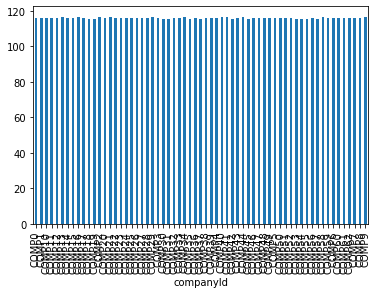

In [4]:
#checking if company ID has any quantitative value
full_data.reset_index(inplace=True,drop=True)
full_data.groupby(['companyId'])['salary'].mean().plot(kind ='bar');

companyId has 63 variables and each class has almost the equal mean.

there is no real value added to the model so we remove the column. 

In [5]:
full_data.drop('companyId',axis = 1,inplace=True)
unique_and_null_categorical(full_data)

JobId is Unique
Unique values in jobId: 999995 

jobType : 
 ['CFO' 'CEO' 'VICE_PRESIDENT' 'MANAGER' 'JUNIOR' 'JANITOR' 'CTO' 'SENIOR'] 
 number of unique values: 8

degree : 
 ['MASTERS' 'HIGH_SCHOOL' 'DOCTORAL' 'BACHELORS' 'NONE'] 
 number of unique values: 5

major : 
 ['MATH' 'NONE' 'PHYSICS' 'CHEMISTRY' 'COMPSCI' 'BIOLOGY' 'LITERATURE'
 'BUSINESS' 'ENGINEERING'] 
 number of unique values: 9

industry : 
 ['HEALTH' 'WEB' 'AUTO' 'FINANCE' 'EDUCATION' 'OIL' 'SERVICE'] 
 number of unique values: 7



### Splitting the data

In [6]:
x_train, x_val, y_train, y_val = train_test_split(full_data.drop(['salary'],axis = 1),full_data['salary'],test_size = 0.3, random_state= 157)

### Baseline model

In [7]:
x_train.set_index('jobId',inplace = True)
x_train_encoded = encode_and_bind(x_train)

In [8]:
model = LinearRegression()
scores = cross_val_score(model,x_train_encoded,y_train,scoring='neg_mean_squared_error')
print("%0.2f mse with a standard deviation of %0.2f for training data" % (abs(scores.mean()), scores.std()))

x_val.set_index('jobId',inplace = True)
x_val_encoded = encode_and_bind(x_val)

model.fit(x_train_encoded,y_train)
y_val_pred = model.predict(x_val_encoded)
print(mean_squared_error(y_val,y_val_pred),'for validation data')

384.36 mse with a standard deviation of 0.94 for training data
384.54462245126416 for validation data


***
**Baseline model gives us a MSE of 384 for both training and validation data**
***
To decrease the MSE further we select few models and try to tune them to achieve better MSE

SGDRegressor, Neural Networks, GBRegressor, Support Vector Regressor

https://machinelearningmastery.com/automate-machine-learning-workflows-pipelines-python-scikit-learn/


* Encode categorical variables with ordinal and one hot encoding
* Apply PCA and check 
* feature scale numerical columns
* Include and remove numerical columns to check if it has an effect

Scaling and non-scaling

OneHotEncoding and Ordinal Coding

trying combination of features

PCA and No-PCA

1. Scale Data using scale_data - "only scales yearsExperience and milesFromMetropolis"
2. ordinal scale jobType and degree using ordinal scale
3. encode all variables with encode_and_bind

In [9]:
def train_model(model, feature_df, target_df, num_procs, mean_mse, cv_std):
    #using 5 fold CV and measuring with MSE 
    neg_mse = cross_val_score(model, feature_df, target_df, cv=5, n_jobs=num_procs, scoring='neg_mean_squared_error')
    #store the mean MSE of the model
    mean_mse[model] = -1.0*np.mean(neg_mse)
    cv_std[model] = np.std(neg_mse)
def print_summary(model, mean_mse, cv_std):
    print('\nModel:\n', model)
    print('Average MSE:\n', mean_mse[model])
    print('Standard deviation during CV:\n', cv_std[model])

In [10]:
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

### 1) SVR

#### No Scaling

In [11]:
x_train_encoded = encode_and_bind(x_train)

In [12]:
kernels = ['rbf','sigmoid','linear','poly']

mse_kernel = []
for i in kernels: 
    svr = SVR(kernel=i,max_iter=500)
    svr.fit(x_train_encoded,y_train)
    y_pred = svr.predict(x_train_encoded)
    mse_kernel.append(mean_squared_error(y_train,y_pred))

In [13]:
mse_df = pd.DataFrame()
mse_kernel = pd.DataFrame(mse_kernel)
mse_df['kernel'] = kernels
mse_df['mse'] = mse_kernel

#### Scaling

In [14]:
x_train_sc,_ = scale_data(x_train)
x_train_sc_enc = encode_and_bind(x_train_sc)

In [15]:
mse_scaled =[]
for i in kernels: 
    svr = SVR(kernel=i,max_iter=500)
    svr.fit(x_train_sc_enc,y_train)
    y_pred = svr.predict(x_train_sc_enc)
    mse_scaled.append(mean_squared_error(y_train,y_pred))

In [16]:
mse_df['scaled_mse'] = pd.DataFrame(mse_scaled)

#### Ordinal Scaled

In [17]:
x_train_ord = ordinal_scale(x_train)
x_train_ord,_ = scale_data(x_train_ord)
x_train_ord_enc = encode_and_bind(x_train_ord)

In [18]:
mse_ord =[]
for i in kernels: 
    svr = SVR(kernel=i,max_iter=500)
    svr.fit(x_train_ord_enc,y_train)
    y_pred = svr.predict(x_train_ord_enc)
    mse_ord.append(mean_squared_error(y_train,y_pred))

mse_df['ordinal_mse'] = pd.DataFrame(mse_ord)

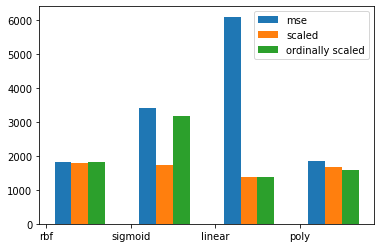

In [19]:
x_axis = np.arange(len(kernels))

# Multi bar Chart

plt.bar(x_axis +0.20, mse_df['mse'], width=0.2, label = 'mse')
plt.bar(x_axis +0.20*2, mse_df['scaled_mse'], width=0.2, label = 'scaled')
plt.bar(x_axis +0.20*3, mse_df['ordinal_mse'], width=0.2, label = 'ordinally scaled')
plt.xticks(x_axis,kernels)
plt.legend()

# Display

plt.show()

### 2) GBR

In [20]:
gbr = GradientBoostingRegressor(max_depth=7,alpha=0.1,verbose=1)
error = cross_val_score(gbr,x_train_encoded,y_train,cv =3, scoring='neg_mean_squared_error')

      Iter       Train Loss   Remaining Time 
         1        1330.0836            1.83m
         2        1190.4314            1.72m
         3        1074.8429            1.67m
         4         979.6346            1.63m
         5         899.2577            1.60m
         6         832.0884            1.57m
         7         773.4663            1.55m
         8         723.8668            1.53m
         9         681.8102            1.51m
        10         645.3304            1.49m
        20         450.8736            1.29m
        30         391.1700            1.13m
        40         369.5596           58.30s
        50         360.2584           48.71s
        60         355.7887           39.09s
        70         352.9547           29.21s
        80         351.2347           19.41s
        90         350.1152            9.67s
       100         349.1116            0.00s
      Iter       Train Loss   Remaining Time 
         1        1330.1313            1.65m
        

In [21]:
print('The mean RMSE and MSE of CV 3 is %f and %f respectively' %(abs(error.mean()),np.sqrt(abs(error.mean()))))

The mean RMSE and MSE of CV 3 is 357.428158 and 18.905770 respectively


In [22]:
param_test1 = {'n_estimators':range(20,101,10)}
gsearch1 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, min_samples_split=500,min_samples_leaf=50,max_depth=8,max_features='sqrt',subsample=0.8,random_state=10), param_grid = param_test1, scoring='neg_mean_squared_error',n_jobs=4, cv=3, verbose=1)
gsearch1.fit(x_train_encoded,y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


GridSearchCV(cv=3,
             estimator=GradientBoostingRegressor(max_depth=8,
                                                 max_features='sqrt',
                                                 min_samples_leaf=50,
                                                 min_samples_split=500,
                                                 random_state=10,
                                                 subsample=0.8),
             n_jobs=4, param_grid={'n_estimators': range(20, 101, 10)},
             scoring='neg_mean_squared_error', verbose=1)

In [23]:
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([918.76445746, 541.22695454,  19.51901269,  28.77073272,
          43.26293818,  43.15917754,  47.38599499,  53.22251264,
          45.86761427]),
  'std_fit_time': array([8.77983818e-02, 4.28172941e+02, 1.08515071e+00, 3.23433453e+00,
         1.83479560e+00, 1.87323783e+00, 1.17939908e-01, 1.77298286e-01,
         5.44905033e+00]),
  'mean_score_time': array([0.44800091, 0.42000524, 0.52399127, 0.80433369, 0.78431241,
         0.88466668, 0.99534218, 1.11203051, 0.94600137]),
  'std_score_time': array([0.02040967, 0.01667588, 0.05314261, 0.06537099, 0.00702393,
         0.0110348 , 0.00046948, 0.03500757, 0.07579076]),
  'param_n_estimators': masked_array(data=[20, 30, 40, 50, 60, 70, 80, 90, 100],
               mask=[False, False, False, False, False, False, False, False,
                     False],
         fill_value='?',
              dtype=object),
  'params': [{'n_estimators': 20},
   {'n_estimators': 30},
   {'n_estimators': 40},
   {'n_estimators': 

In [24]:
param_test2 = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}
gsearch2 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, n_estimators=80, max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test2, scoring='neg_mean_squared_error',n_jobs=4,verbose=2, cv=3)
gsearch2.fit(x_train_encoded,y_train)
gsearch2.cv_results_, gsearch2.best_params_, gsearch2.best_score_

Fitting 3 folds for each of 30 candidates, totalling 90 fits


({'mean_fit_time': array([22.31935   , 22.00164302, 21.88097954, 21.88866003, 21.9633309 ,
         29.29934176, 29.01033084, 28.91900762, 28.99998633, 28.69765902,
         35.70966538, 35.64866551, 36.17366624, 35.7346681 , 34.94897127,
         40.78329341, 40.18933058, 39.89666581, 39.7479492 , 39.55733124,
         45.36567108, 44.45766838, 43.9486661 , 44.18132933, 43.07599489,
         48.89336594, 47.30899779, 46.6650273 , 46.18566362, 36.43230351]),
  'std_fit_time': array([0.03753031, 0.28879746, 0.10602336, 0.03168393, 0.05771856,
         0.24974321, 0.17447431, 0.11527078, 0.05548701, 0.28698664,
         0.11651449, 0.31444935, 0.08546489, 0.06638172, 0.29440884,
         0.25472734, 0.08208568, 0.05217117, 0.13296994, 0.05618391,
         0.23387195, 0.10896268, 0.11721301, 0.33468278, 0.29362524,
         0.43952202, 0.14583766, 0.05686913, 0.03805368, 4.64745979]),
  'mean_score_time': array([0.68365153, 0.70900289, 0.73335894, 0.77433578, 0.68266948,
         0.813658

In [25]:
param_test3 = {'min_samples_split':range(1000,2100,200), 'min_samples_leaf':range(30,71,10)}
gsearch3 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, n_estimators=80,max_depth=7,max_features='sqrt', subsample=0.8, random_state=10), 
param_grid = param_test3, scoring='neg_mean_squared_error',n_jobs=4, cv=3)
gsearch3.fit(x_train_encoded,y_train)
gsearch3.cv_results_, gsearch3.best_params_, gsearch3.best_score_

({'mean_fit_time': array([28.55966123, 28.45068598, 28.21330468, 28.06566175, 28.33200336,
         28.16433207, 28.35397696, 28.24636412, 28.40064669, 28.18533548,
         28.3750031 , 28.36933613, 28.7163322 , 29.01033584, 29.37398664,
         29.35432704, 29.45034027, 28.56168421, 28.45967118, 28.56232897,
         28.74399344, 28.33666571, 28.43299953, 28.33362889, 28.53100363,
         28.66100105, 28.64866265, 28.47665763, 29.84000238, 21.95266994]),
  'std_fit_time': array([0.09862938, 0.06240407, 0.12739847, 0.04768182, 0.06788698,
         0.15098822, 0.05788473, 0.12986317, 0.06057665, 0.13186965,
         0.13626316, 0.08344914, 0.18942453, 0.35473996, 0.24439158,
         0.09389809, 0.09407214, 0.57806818, 0.10510708, 0.07603446,
         0.08184932, 0.12514049, 0.0856664 , 0.04325471, 0.14659013,
         0.08333345, 0.08092498, 0.1546684 , 0.05649373, 5.33267294]),
  'mean_score_time': array([0.79899891, 0.80430913, 0.83335908, 0.8279988 , 0.81699951,
         0.819337

In [26]:
param_test4 = {'max_features':range(7,20,2)}
gsearch4 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, n_estimators=80,max_depth=11, min_samples_split=800, min_samples_leaf=60, subsample=0.8, random_state=10),
param_grid = param_test4, scoring='neg_mean_squared_error',n_jobs=4, cv=3,verbose=3)
gsearch4.fit(x_train_encoded,y_train)
gsearch4.cv_results_,gsearch4.best_params_,gsearch4.best_score_

Fitting 3 folds for each of 7 candidates, totalling 21 fits


({'mean_fit_time': array([49.43066104, 58.6639986 , 67.52532768, 76.75932964, 85.74632939,
         93.58732375, 85.59933472]),
  'std_fit_time': array([ 0.12213569,  0.16788033,  0.46226305,  0.30507404,  0.41634339,
          0.43835055, 14.30349827]),
  'mean_score_time': array([1.17967065, 1.13666511, 1.12966951, 1.1089983 , 1.12198869,
         1.10266534, 0.94666473]),
  'std_score_time': array([0.05865548, 0.02390865, 0.01087035, 0.02384559, 0.01818502,
         0.00758533, 0.05246502]),
  'param_max_features': masked_array(data=[7, 9, 11, 13, 15, 17, 19],
               mask=[False, False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'max_features': 7},
   {'max_features': 9},
   {'max_features': 11},
   {'max_features': 13},
   {'max_features': 15},
   {'max_features': 17},
   {'max_features': 19}],
  'split0_test_score': array([-358.58214853, -358.11369011, -357.77948066, -357.63106355,
         -357.7804679 , -357.59

The Best parameters so far obtained are: 
1) min_samples_split = 800

2) min_samples_leaf = 60

3) max_depth = 11

4) max_features = 13

In [27]:
param_test5 = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
gsearch5 = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, n_estimators=80,max_depth=11,min_samples_split=800, min_samples_leaf=60, subsample=0.8, random_state=10,max_features=13),
param_grid = param_test5, scoring='neg_mean_squared_error',n_jobs=4, cv=3,verbose=4)
gsearch5.fit(x_train_encoded,y_train)
gsearch5.cv_results_, gsearch5.best_params_, gsearch5.best_score_

Fitting 3 folds for each of 6 candidates, totalling 18 fits


({'mean_fit_time': array([59.53966371, 67.57866335, 71.65499679, 75.91600092, 80.53766886,
         66.33499813]),
  'std_fit_time': array([ 0.11632321,  0.15461437,  0.26752845,  0.20417535,  0.15435101,
         11.39332652]),
  'mean_score_time': array([1.09733526, 1.08933934, 1.0896697 , 1.07669512, 1.11832905,
         0.94967024]),
  'std_score_time': array([0.02661502, 0.01976643, 0.0037686 , 0.00522694, 0.00805681,
         0.07808525]),
  'param_subsample': masked_array(data=[0.6, 0.7, 0.75, 0.8, 0.85, 0.9],
               mask=[False, False, False, False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'subsample': 0.6},
   {'subsample': 0.7},
   {'subsample': 0.75},
   {'subsample': 0.8},
   {'subsample': 0.85},
   {'subsample': 0.9}],
  'split0_test_score': array([-357.83325123, -357.68915306, -357.73886256, -357.63106355,
         -357.7323972 , -357.63466448]),
  'split1_test_score': array([-357.38303289, -357.28080745, -357.18800619, -3

In [28]:
gbm_tuned_1 = GradientBoostingRegressor(learning_rate=0.05, n_estimators=160,max_depth=11, min_samples_split=800,min_samples_leaf=60, subsample=0.6, random_state=10, max_features=13)
gbm_tuned_1.fit(x_train_encoded, y_train)

#Predict training set:
dtrain_predictions = gbm_tuned_1.predict(x_train_encoded)
#dtrain_predprob = gbm_tuned_1.predict_proba(x_train_encoded)[:,1]
print(mean_squared_error(y_train,dtrain_predictions))


348.36236889576367


In [29]:
gbm_tuned_2 = GradientBoostingRegressor(learning_rate=0.05, n_estimators=800,max_depth=11, min_samples_split=800,min_samples_leaf=60, subsample=0.6, random_state=10, max_features=13)
gbm_tuned_2.fit(x_train_encoded, y_train)

#Predict training set:
dtrain_predictions = gbm_tuned_2.predict(x_train_encoded)
#dtrain_predprob = gbm_tuned_1.predict_proba(x_train_encoded)[:,1]
print(mean_squared_error(y_train,dtrain_predictions))


335.4503335574303


In [33]:
gbm_tuned_3 = GradientBoostingRegressor(learning_rate=0.05, n_estimators=800,max_depth=11, min_samples_split=800,min_samples_leaf=60, subsample=0.6, random_state=10, max_features=13)
error_1 = cross_val_score(gbm_tuned_3,x_train_encoded,y_train,cv =3, scoring='neg_mean_squared_error')

In [34]:
gbm_tuned_4 = GradientBoostingRegressor(learning_rate=0.05, n_estimators=160,max_depth=11, min_samples_split=800,min_samples_leaf=60, subsample=0.6, random_state=10, max_features=13)
error_2 = cross_val_score(gbm_tuned_4,x_train_encoded,y_train,cv =3, scoring='neg_mean_squared_error')

In [35]:
print(error_1.mean(),error_2.mean())

-360.62520018141777 -356.82856983346187


In [78]:
gbm4_pred = gbm_tuned_1.predict(x_val_encoded)
print(mean_squared_error(y_val,gbm4_pred))

356.8859952136066


### Deep Neural Networks 

In [71]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import Dropout

### No dropouts

In [60]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = x_train_encoded.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mse'])
NN_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               4096      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                                 
 dense_3 (Dense)             (None, 256)               65792     
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 168,961
Trainable params: 168,961
Non-trainable params: 0
_________________________________________________________________


In [62]:
NN_model.fit(x_train_encoded, y_train, epochs=20, batch_size=32, validation_split = 0.2)

Epoch 1/20
17500/17500 [==============================] - 40s 2ms/step - loss: 15.8685 - mse: 388.9250 - val_loss: 16.2036 - val_mse: 416.1398
Epoch 2/20
17500/17500 [==============================] - 39s 2ms/step - loss: 15.7101 - mse: 379.4499 - val_loss: 15.6391 - val_mse: 376.6476
Epoch 3/20
17500/17500 [==============================] - 39s 2ms/step - loss: 15.6237 - mse: 374.2782 - val_loss: 15.4727 - val_mse: 363.9279
Epoch 4/20
17500/17500 [==============================] - 39s 2ms/step - loss: 15.5730 - mse: 371.0078 - val_loss: 15.9858 - val_mse: 396.8606
Epoch 5/20
17500/17500 [==============================] - 39s 2ms/step - loss: 15.5316 - mse: 368.1833 - val_loss: 15.7224 - val_mse: 380.9400
Epoch 6/20
17500/17500 [==============================] - 39s 2ms/step - loss: 15.5039 - mse: 366.8290 - val_loss: 15.4337 - val_mse: 360.8222
Epoch 7/20
17500/17500 [==============================] - 39s 2ms/step - loss: 15.4983 - mse: 366.4758 - val_loss: 15.6332 - val_mse: 377.5757

In [64]:
predictions = NN_model.predict(x_val_encoded)
print(mean_squared_error(y_val,predictions))

363.6419389832914


#### activation layer ReLu, with less hidden layers and nodes 

In [66]:
NN_model_2 = Sequential()

# The Input Layer :
NN_model_2.add(Dense(64, kernel_initializer='normal',input_dim = x_train_encoded.shape[1], activation='selu'))

# The Hidden Layers :
NN_model_2.add(Dense(128, kernel_initializer='normal',activation='selu'))
NN_model_2.add(Dense(128, kernel_initializer='normal',activation='selu'))

# The Output Layer :
NN_model_2.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model_2.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mse'])
NN_model_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 64)                2048      
                                                                 
 dense_10 (Dense)            (None, 128)               8320      
                                                                 
 dense_11 (Dense)            (None, 128)               16512     
                                                                 
 dense_12 (Dense)            (None, 1)                 129       
                                                                 
Total params: 27,009
Trainable params: 27,009
Non-trainable params: 0
_________________________________________________________________


In [67]:
NN_model_2.fit(x_train_encoded, y_train, epochs=20, batch_size=32, validation_split = 0.2)

Epoch 1/20
17500/17500 [==============================] - 35s 2ms/step - loss: 16.1497 - mse: 419.2448 - val_loss: 15.8127 - val_mse: 385.5827
Epoch 2/20
17500/17500 [==============================] - 34s 2ms/step - loss: 15.7156 - mse: 379.9995 - val_loss: 15.6240 - val_mse: 372.2517
Epoch 3/20
17500/17500 [==============================] - 34s 2ms/step - loss: 15.6320 - mse: 374.9365 - val_loss: 15.5052 - val_mse: 366.3273
Epoch 4/20
17500/17500 [==============================] - 35s 2ms/step - loss: 15.5470 - mse: 369.5513 - val_loss: 15.4935 - val_mse: 365.9038
Epoch 5/20
17500/17500 [==============================] - 35s 2ms/step - loss: 15.4972 - mse: 366.2870 - val_loss: 15.3919 - val_mse: 359.2046
Epoch 6/20
17500/17500 [==============================] - 35s 2ms/step - loss: 15.4576 - mse: 363.9457 - val_loss: 15.4002 - val_mse: 359.8665
Epoch 7/20
17500/17500 [==============================] - 35s 2ms/step - loss: 15.4420 - mse: 363.1600 - val_loss: 15.6661 - val_mse: 371.6826

In [68]:
predictions_2 = NN_model_2.predict(x_val_encoded)
print(mean_squared_error(y_val,predictions_2))

357.7474572925096


### with dropouts

In [72]:
NN_model_3 = Sequential()

# The Input Layer :
NN_model_3.add(Dense(64, kernel_initializer='normal',input_dim = x_train_encoded.shape[1], activation='selu'))
NN_model_3.add(Dropout(0.2))
# The Hidden Layers :
NN_model_3.add(Dense(128, kernel_initializer='normal',activation='selu'))
NN_model_3.add(Dropout(0.2))
NN_model_3.add(Dense(128, kernel_initializer='normal',activation='selu'))
NN_model_3.add(Dropout(0.2))
# The Output Layer :
NN_model_3.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model_3.compile(loss='mean_absolute_error', optimizer='adamax', metrics=['mse'])
NN_model_3.summary()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 64)                2048      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_18 (Dense)            (None, 1)                

In [73]:
NN_model_3.fit(x_train_encoded, y_train, epochs=20, batch_size=32, validation_split = 0.2)

Epoch 1/20
17500/17500 [==============================] - 41s 2ms/step - loss: 17.8609 - mse: 535.7599 - val_loss: 15.7140 - val_mse: 382.4869
Epoch 2/20
17500/17500 [==============================] - 41s 2ms/step - loss: 16.5945 - mse: 433.9010 - val_loss: 15.8874 - val_mse: 385.0001
Epoch 3/20
17500/17500 [==============================] - 41s 2ms/step - loss: 16.4879 - mse: 426.9828 - val_loss: 15.8268 - val_mse: 388.6416
Epoch 4/20
17500/17500 [==============================] - 41s 2ms/step - loss: 16.4595 - mse: 425.8032 - val_loss: 15.5908 - val_mse: 372.9740
Epoch 5/20
17500/17500 [==============================] - 41s 2ms/step - loss: 16.4165 - mse: 423.1640 - val_loss: 15.5597 - val_mse: 369.5881
Epoch 6/20
17500/17500 [==============================] - 41s 2ms/step - loss: 16.4045 - mse: 422.7178 - val_loss: 15.5945 - val_mse: 371.9797
Epoch 7/20
17500/17500 [==============================] - 41s 2ms/step - loss: 16.3765 - mse: 421.2268 - val_loss: 15.5669 - val_mse: 371.7350

In [75]:
predictions_3 = NN_model_3.predict(x_val_encoded)
print(mean_squared_error(y_val,predictions_3))

363.7070329274651
